In [1]:
import sys
sys.path.append('./../')

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import importlib
from statsmodels.nonparametric.kde import KDEUnivariate
from collections import Counter
import pandas as pd

In [3]:
import optim as opt
import helpertests as tst
import sparsedense as spd

In [8]:
test = 'facebook'
np.random.seed(110104)

In [12]:
links = np.genfromtxt('{}.txt'.format(test), delimiter=' ', dtype=int)
g = nx.Graph()
g.add_edges_from(links)
net = nx.adjacency_matrix(g).toarray().astype(int)
for i in range(net.shape[0]):
    net[i, i] = 1

In [6]:
# with open('{}.pkl'.format(test), 'rb') as f:
#     runs = pickle.load(f)

In [7]:
# alpha, sigma, c, num_cliques = runs['alphas'][-1], runs['sigmas'][-1], runs['cs'][-1], runs['Ks'][-1]
# alpha, sigma, c, num_cliques

(0.939554602576684, 0.0001, 398.44837657292373, 8706)

In [8]:
def gen_rcc_samples(nsamples, alpha, sigma, c, num_cliques):
    for k in range(nsamples):
        Z = opt.sample_from_ibp(num_cliques, alpha=alpha, sigma=sigma, c=c)
        net = Z.transpose() @ Z
        K, N = Z.shape
        links = []
        for i in range(N - 1):
            for j in range(i + 1, N):
                if net[i, j] >= 1:
                    links.append([i, j])
        np.savetxt('rcc_runs/{}.tsv'.format(k), np.array(links), delimiter='\t', fmt='%d')

In [9]:
nsamples = 25
gen_rcc_samples(nsamples, alpha, sigma, c, num_cliques)

In [10]:
def test_samples(path, n=25, mc_size=500, verbose=True, offset=0, zeropad=False, nodeoffset=0):
    
    num_nodes, num_edges, edge_node, density, deg, max_clique_node, clust_coeff, conn_comp_largest, short_paths = [], [], [], [], [], [], [], [], []

    for i in range(1, n):
        strpattern = '{}.tsv' if not zeropad else '{:02d}.tsv'
        links = np.genfromtxt(path + strpattern.format(i+offset), delimiter='\t', dtype=int)
        g = nx.Graph()
        for i, j in links:
            if i != j:
                g.add_edge(i - nodeoffset, j - nodeoffset)

        num_nodes_i, num_edges_i, edge_node_ratio_i, density_i, deg_i, max_clique_node_i, clust_coeff_i, conn_comp_i, short_paths_i = \
            tst.test_stats(g, mc_size=mc_size, verbose=False, return_results=True)

        num_nodes.append(num_nodes_i)
        num_edges.append(num_edges_i)
        edge_node.append(edge_node_ratio_i)
        density.append(density_i)
        deg.append(deg_i)
        max_clique_node.append(max_clique_node_i)
        clust_coeff.append(clust_coeff_i)
        conn_comp_largest.append(conn_comp_i / num_nodes_i)
        short_paths.append(short_paths_i)

    if verbose:
        print("- num nodes: {:f}, {:f}".format(np.mean(num_nodes), np.std(num_nodes)))
        print("- num edges: {:f}, {:f}".format(np.mean(num_edges), np.std(num_edges)))
        print("- edge node ratio: {:2.2f}, {:f}".format(np.mean(edge_node), np.std(edge_node)))
        print("- density (1000x): {:2.6f}, {:f}".format(1000 * np.mean(density), 1000 * np.std(density)))
        print("- mean degree: {:2.2f}, {:f}".format(np.mean(deg), np.std(deg)))
        print("- mean maximal clique containing node: {:2.2f}, {:f}".format(np.mean(max_clique_node), np.std(max_clique_node)))
        print("- clustering coefficient: {:2.2f}, {:f}".format(np.mean(clust_coeff), np.std(clust_coeff)))
        print("- connected component sizes (largest): {}, {:f}".format(np.mean(conn_comp_largest), np.std(conn_comp_largest)))
        print("- mean distance between nodes (largest conn. comp.): {:2.2f}, {:f}".format(np.mean(short_paths), np.std(short_paths)))  

In [11]:
tst.test_stats(g)

- num nodes: 1172
- num edges: 4293
- edge node ratio: 3.66
- density: 0.006256
- mean degree: 7.33
- mean maximal clique containing node: 3.22
- clustering coefficient: 0.23
- connected component sizes (top 5): [1166, 2, 2, 2]
- mean distance between nodes (largest conn. comp.): 3.53


In [12]:
test_samples('rcc_runs/')

- num nodes: 987.041667, 33.630937
- num edges: 3721.583333, 396.227199
- edge node ratio: 3.76, 0.319676
- density (1000x): 7.631725, 0.552576
- mean degree: 7.53, 0.639351
- mean maximal clique containing node: 3.21, 0.100591
- clustering coefficient: 0.26, 0.015328
- connected component sizes (largest): 0.9838067172554391, 0.006632
- mean distance between nodes (largest conn. comp.): 3.44, 0.106656


In [13]:
test_samples('bnpgraph_runs/enron_', offset=1, nodeoffset=1)

- num nodes: 1181.958333, 51.632902
- num edges: 4519.000000, 552.734038
- edge node ratio: 3.81, 0.340023
- density (1000x): 6.454308, 0.440453
- mean degree: 7.63, 0.680046
- mean maximal clique containing node: 2.59, 0.108314
- clustering coefficient: 0.05, 0.008079
- connected component sizes (largest): 0.9855017520039464, 0.005060
- mean distance between nodes (largest conn. comp.): 3.43, 0.087757


In [14]:
test_samples('krongen_runs/enron_', offset=1, zeropad=True)

- num nodes: 1599.541667, 15.532169
- num edges: 7733.833333, 12.181498
- edge node ratio: 4.84, 0.045520
- density (1000x): 6.050963, 0.115120
- mean degree: 9.67, 0.091040
- mean maximal clique containing node: 2.73, 0.049085
- clustering coefficient: 0.09, 0.006172
- connected component sizes (largest): 0.9996894047172272, 0.000538
- mean distance between nodes (largest conn. comp.): 3.02, 0.030918


In [15]:
def fit_kde(x, grid):
    resol = len(grid)
    d = np.zeros(resol)
    kde = KDEUnivariate(x)
    kde.fit()
    d = kde.evaluate(grid)    
    return d

def fit_count(x, grid):
    cnt = Counter(x)
    d = np.array([cnt[y] for y in grid]) / len(x)
    return d

def degree_clique_density_runs(path, deg_grid, clique_grid, n = 25, offset=0, zeropad=False, nodeoffset=0):
    deg_dens = np.zeros(len(deg_grid))
    clique_dens = np.zeros(len(clique_grid))
    
    for k in range(n):
        strpattern = '{}.tsv' if not zeropad else '{:02d}.tsv'
        links = np.genfromtxt(path + strpattern.format(k+offset), delimiter='\t', dtype=int)
        g = nx.Graph()
        for i, j in links:
            if i != j:
                g.add_edge(i - nodeoffset, j - nodeoffset)



        degs = np.array([nx.degree(g, i) for i in g.nodes()], dtype=float)
        clique = np.array([nx.node_clique_number(g, i) for i in g.nodes()], dtype=float)
        
        deg_dens += fit_kde(degs, deg_grid) / n  
        clique_dens += fit_count(clique, clique_grid) / n  
        
    return deg_dens, clique_dens

def degree_clique_density_graph(g, deg_grid, clique_grid):
    degs = np.array([nx.degree(g, i) for i in g.nodes()], dtype=float)
    clique = np.array([nx.node_clique_number(g, i) for i in g.nodes()], dtype=float)

    deg_dens = fit_kde(degs, deg_grid)
    clique_dens = fit_count(clique, clique_grid) 
        
    return deg_dens, clique_dens

In [16]:
deg_grid = np.linspace(1, 45, 50)
clique_grid = np.arange(2, 20)

deg_dens_rcc, clique_dens_rcc = degree_clique_density_runs('rcc_runs/', deg_grid, clique_grid)
deg_dens_bnp, clique_dens_bnp = degree_clique_density_runs('bnpgraph_runs/enron_', deg_grid, clique_grid, offset=1, nodeoffset=1)
deg_dens_krongen, clique_dens_krongen = degree_clique_density_runs('krongen_runs/enron_', deg_grid, clique_grid, offset=1, zeropad=True)

In [17]:
deg_dens_orig, clique_dens_orig = degree_clique_density_graph(g, deg_grid, clique_grid)

In [18]:
deg_df = pd.DataFrame({
    'Truth': deg_dens_orig, 
    'RCC': deg_dens_rcc, 
    'BNPGraph': deg_dens_bnp,
    'Kron(2x2)': deg_dens_krongen}, index=deg_grid)
maxclique_df = pd.DataFrame({
    'Truth': clique_dens_orig, 
    'RCC': clique_dens_rcc,
    'BNPGraph': clique_dens_bnp,
    'Kron(2x2)': clique_dens_krongen}, index=clique_grid)

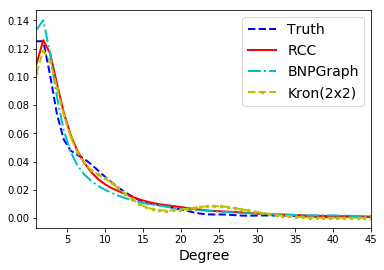

In [19]:
style = ['b--','r-','c-.', 'y--.']
deg_df.plot(style=style, markersize=5, linewidth=2, figsize = (6, 4))
plt.legend(fontsize=14) # using a size in points
plt.xlim(1, 45)
plt.xlabel("Degree", fontsize=14)
# plt.ylabel("Density")
# plt.title("Degree distribution")
plt.savefig('enron_degree_dist.png', format="PNG")
plt.show()

In [20]:
# style = ['b--','r-','c-.']
# maxclique_df.plot(style=style, markersize=5, linewidth=2, figsize = (6, 4))
# plt.legend(fontsize=14) # using a size in points
# plt.xlim(2, 15)
# plt.xlabel("Maximal clique size per node", fontsize=14)
# # plt.ylabel("Density")
# # plt.title("Degree distribution")
# plt.savefig('enron_maximal_clique_dist.png', format="PNG")
# plt.show()

In [21]:
def fit_count(x, grid):
    cnt = Counter(x)
    d = np.array([cnt[y] for y in grid]) / len(x)
    return d

def clique_density_runs(path, clique_grid, n = 25, offset=0, zeropad=False, nodeoffset=0):
    counts = np.zeros((len(clique_grid), n))
    
    for k in range(n):
        strpattern = '{}.tsv' if not zeropad else '{:02d}.tsv'
        links = np.genfromtxt(path + strpattern.format(k+offset), delimiter='\t', dtype=int)
        g = nx.Graph()
        for i, j in links:
            if i != j:
                g.add_edge(i - nodeoffset, j - nodeoffset)

        clique = np.array([nx.node_clique_number(g, i) for i in g.nodes()], dtype=float)    
        counts[:,k] = fit_count(clique, clique_grid)
    
    means = np.mean(counts, 1)
    std = np.std(counts, 1)
        
    return means, std

def clique_density_graph(g, clique_grid, n = 25, offset=0):
    clique = [nx.node_clique_number(g, i) for i in g.nodes()]
    counts = fit_count(clique, clique_grid)
    
    return counts

In [22]:
clique_grid = np.arange(2, 7)
clique_means_rcc, clique_std_rcc = clique_density_runs('rcc_runs/', clique_grid)
clique_means_bnp, clique_std_bnp = clique_density_runs('bnpgraph_runs/enron_', clique_grid, offset=1, nodeoffset=1)
clique_means_krongen, clique_std_krongen = clique_density_runs('krongen_runs/enron_', clique_grid, offset=1, zeropad=True)
clique = clique_density_graph(g, clique_grid)
df = pd.DataFrame({'Truth': clique, 'RCC': clique_means_rcc, 'BNPGraph': clique_means_bnp, 'Kron(2x2)': clique_means_krongen}, index=clique_grid)

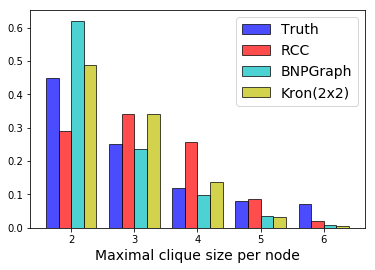

In [23]:
style = ['b','r','c', 'y']
df.plot.bar(width=.8, figsize=(6,4), alpha=0.7, rot=0, color=style, edgecolor = 'black')
plt.legend(fontsize=14)
plt.xlabel('Maximal clique size per node', fontsize=14)
plt.savefig('enron_maximal_clique_dist.png', format="PNG")